Import Libraries

In [4]:
# ensures that matplotlib plots are disdplayed inside the notebook 
%matplotlib inline

# provides access to system-specific parameters and functions
import sys
# helps with file and directory operations, enviornment variables, and process control
import os
# for image loading, processing, and manipulation
import cv2
import shutil

import matplotlib # for plotting and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import axes3d # for creating 3D plots
from tqdm import tqdm # library used for displaying progress bars for loops
from sklearn.model_selection import train_test_split


import pathlib
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random 
print("Version information")

print("python: {}".format(sys.version))
print("matplotlib: {}".format(matplotlib.__version__))
print("numpy: {}".format(np.__version__))
print("tensorflow: {}".format(tf.__version__))
print("current working directory:", os.getcwd()) # prints curr working directory
print("list of files:", os.listdir())  # Lists the files in the current directory
print("cv2 version:", cv2.__version__)
print("tensorflow: {}".format(tf.__version__))

# Load image
import imageio

# automatically reloads modules before executing code
%load_ext autoreload
%autoreload 2

Version information
python: 3.9.20 (main, Oct  3 2024, 07:38:01) [MSC v.1929 64 bit (AMD64)]
matplotlib: 3.9.2
numpy: 1.26.4
tensorflow: 2.10.1
current working directory: c:\Users\wiito\Documents\Github\Alzheimer-Detection\notebooks
list of files: ['1_CNN.ipynb', '2_Model_2.ipynb', '3_Model_3.ipynb', 'preprocessing.py']
cv2 version: 4.10.0
tensorflow: 2.10.1


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 998617090942328203
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5718933504
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4544608287748100403
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [6]:
DATASET_PATH = "../Data/"
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.3
IMAGE_SIZE = (248, 496)
data_dir = pathlib.Path(DATASET_PATH)
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]


Checking for corrupt images

In [ ]:
from PIL import Image
import os

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            try:
                img = Image.open(os.path.join(root, file))
                img.load()  # Load image to detect issues
            except Exception as e:
                print(f"Corrupted image detected: {os.path.join(root, file)} - {e}")

directory setup and split data

In [8]:
print(data_dir)
print(data_dir.exists())

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
        labels="inferred",
        directory=data_dir,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        seed=0,
        image_size=IMAGE_SIZE,
        subset='both',
        color_mode="grayscale")
test_ds = val_ds.shard(num_shards=3, index=0).concatenate(
               val_ds.shard(num_shards=3, index=1))
val_ds = val_ds.shard(num_shards=3, index=2)

train_ds = train_ds.shuffle(buffer_size=1000)
test_ds = test_ds.shuffle(buffer_size=1000)
val_ds = val_ds.shuffle(buffer_size=1000)
# train = 0.8 test = 0.1 val = 0.1
print("data has been split")

..\Data
True
Found 86437 files belonging to 4 classes.
Using 60506 files for training.
Using 25931 files for validation.
data has been split


Visualize batch of images from dataset 

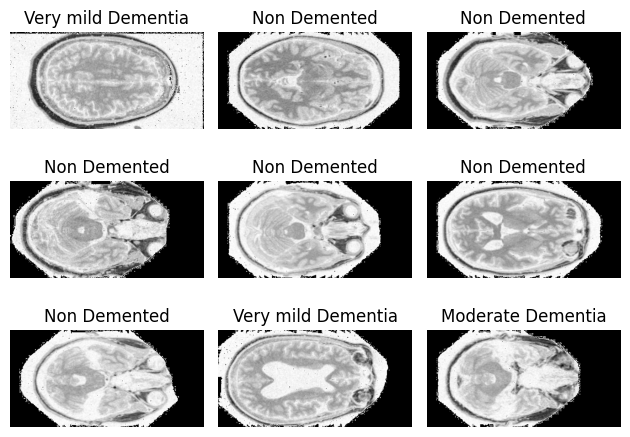

In [9]:
def image_sample_visualization(dataset):
    label_to_classname = dict(zip(range(4), classes))
    dataset = dataset.shuffle(buffer_size=1000)
    iterator = dataset.as_numpy_iterator()
    # get batch of images and labels
    images = [iterator.next() for _ in range(9)]
    for i in range(9):
        plt.subplot(3, 3, i + 1)

        imgs, labels = images[i]
        index = random.randint(0, len(imgs) - 1)
        img = imgs[index]
        label = labels[index]

        img = (img * 255).astype(np.uint8)

        # show image
        plt.imshow(img, cmap='gray')
        plt.axis("off")
        plt.title(label_to_classname[label])

    plt.tight_layout()
    plt.show()
image_sample_visualization(test_ds)

# Actual model?

In [ ]:
num_classes = len(classes)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(*IMAGE_SIZE, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
print(history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 248, 496, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 248, 496, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 248, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 248, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 124, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 124, 64)       1

In [ ]:
results = model.evaluate(test_ds)

In [20]:
# predict on one in test ds


for images, labels in test_ds.take(1):
    prediction = model.predict_on_batch(images)
    predicted_labels = np.argmax(prediction, axis=1)
    
    correct = 0
    num = 0
    
    for predicted, actual in zip(predicted_labels, labels):
        num += 1
        if predicted == actual:
            correct += 1
            
    print(correct/num)
    
    

1.0


In [21]:
model.save('cnn.keras')

## Visualization

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()